In [1]:

import torch 
from torch import nn 

from rbi.utils.nets import generate_dense_net
from rbi.utils.tasks import InferenceTask

class ExchangableLinearLayer(nn.Module):
    def __init__(self, input_dim, output_dim, output_dim_phi=100, aggregation_dim=1, aggregation_fn = torch.sum, hidden_dims=[50, 50], nonlinearity=nn.ReLU):
        super().__init__()
        self.aggregation_dim = aggregation_dim
        self.phi = generate_dense_net(input_dim, output_dim=output_dim_phi, hidden_dims=hidden_dims, nonlinearity=nonlinearity, output_nonlinearity=nn.Identity())
        self.g = generate_dense_net(output_dim_phi, output_dim, hidden_dims=hidden_dims, nonlinearity=nonlinearity, output_nonlinearity=nn.Identity())
        self.aggregation_fn = aggregation_fn

    def forward(self, x):
        h = self.phi(x)
        with torch.no_grad():
            h = torch.nan_to_num(h, 0.)
        out = self.aggregation_fn(h, axis=self.aggregation_dim)
        out = self.g(out)
        return out

In [8]:
torch.nan

nan

In [2]:
from pyro.distributions import ConditionalDistribution

In [3]:
class GLRTask(InferenceTask):
    def __init__(self, feature_mapping, min_N=1, max_N = 100,x_bound=10, prior_mean=0., prior_scale=1., likelihood_scale=1.):
        self.max_N = max_N
        self.min_N = min_N
        self.likelihood_scale = likelihood_scale
        self.x_bound = x_bound
        self.output_dim = feature_mapping(torch.randn((1, 1))).shape[-1]

        self.feature_mapping = feature_mapping 

        prior = torch.distributions.Normal(prior_mean*torch.ones(self.output_dim), prior_scale*torch.ones(self.output_dim))

        def simulator(theta, x=None):
            if x is None:
                x = self.generate_datasets_x(theta.shape[0])
                
            phi_x = self.feature_mapping(x).reshape(*x.shape[:-1], self.output_dim)
            y = torch.einsum("ijd, id -> ij", phi_x, theta)
            y += torch.randn_like(y)*likelihood_scale
            y = y.reshape(x.shape)
            return torch.concat([phi_x,y], dim=-1)
        
        super().__init__(prior, None, simulator)

    def get_true_posterior(self):
        
        class Posterior(ConditionalDistribution):
            def condition(useless_self, context):
                if len(context.shape) == 2:
                    context = context.unsqueeze(0)

                batch_shape = context.shape[0]
                means = []
                covs = []
                for i in range(batch_shape):
                    phi_x = context[i,...,:-1]
                    y = context[i,...,-1]

                    mask = torch.isfinite(y)

                    phi_x = phi_x[mask]
                    y = y[mask]


                    c = phi_x@phi_x.T

                    prior_mean = self.prior.mean 
                    prior_cov = torch.eye(prior_mean.shape[-1])*self.prior.variance 

                    likelihood_cov = torch.eye(c.shape[-1])*self.likelihood_scale**2

                    c += likelihood_cov
                    
                    L_c = torch.cholesky(c)
                    c_inv = torch.cholesky_inverse(L_c)



                    post_m = prior_mean + prior_cov@phi_x.T@c_inv@(y - phi_x@prior_mean)
                    post_cov = prior_cov - prior_cov@phi_x.T@c_inv@phi_x@prior_cov

                    means.append(post_m.unsqueeze(0))
                    covs.append(post_cov.unsqueeze(0))


                return torch.distributions.MultivariateNormal(torch.stack(means), torch.stack(covs))
            
        return Posterior()

    def generate_datasets_x(self, N):
        if self.max_N > self.min_N:
            Ns = torch.randint(1, self.max_N, (N,))
            x = torch.rand((N, self.max_N,1))*2*self.x_bound - self.x_bound
            for i in range(N):
                x[i,Ns[i]:] = torch.nan
            return x
        else:
            return torch.rand((N, self.min_N,1))*2*self.x_bound - self.x_bound
        


In [273]:
from rbi.utils.nets import MultivariateGaussianNet
from rbi.loss.loss_fn import NLLLoss

net = MultivariateGaussianNet(20, 2, hidden_dims=[200, 200],input_transform=ExchangableLinearLayer(3, 20, hidden_dims=[200, 200]))
loss_fn = NLLLoss(net)


In [5]:
def phi(x):
    return torch.stack([torch.ones_like(x), x], dim=-1)

In [6]:
task = GLRTask(phi, min_N=1,max_N=10, likelihood_scale=0.5, prior_scale=1.)
simulator = task.get_simulator()
prior = task.get_prior()

trainloader, _,_ = task.get_train_test_val_dataset(100000, 1, 1, batch_size=1000)

In [ ]:
def likelihood_fn(xy):
    

In [279]:
optim = torch.optim.Adam(net.parameters(), lr=1e-4)
loss_fn.train()
for i in range(50):
    trainloader, _,_ = task.get_train_test_val_dataset(20000, 1, 1, batch_size=5000)
    for x, theta in trainloader:
        optim.zero_grad()
        l = loss_fn(x, theta)
        l.backward()
        optim.step()
    print(l)
        

tensor([-0.1757], grad_fn=<AddBackward0>)
tensor([-0.1800], grad_fn=<AddBackward0>)
tensor([-0.2220], grad_fn=<AddBackward0>)
tensor([-0.2454], grad_fn=<AddBackward0>)
tensor([-0.2927], grad_fn=<AddBackward0>)
tensor([-0.2747], grad_fn=<AddBackward0>)
tensor([-0.3373], grad_fn=<AddBackward0>)
tensor([-0.3772], grad_fn=<AddBackward0>)
tensor([-0.3643], grad_fn=<AddBackward0>)
tensor([-0.4211], grad_fn=<AddBackward0>)
tensor([-0.4197], grad_fn=<AddBackward0>)
tensor([-0.4796], grad_fn=<AddBackward0>)
tensor([-0.4151], grad_fn=<AddBackward0>)
tensor([-0.4577], grad_fn=<AddBackward0>)
tensor([-0.4778], grad_fn=<AddBackward0>)
tensor([-0.4770], grad_fn=<AddBackward0>)
tensor([-0.4696], grad_fn=<AddBackward0>)
tensor([-0.5186], grad_fn=<AddBackward0>)
tensor([-0.5160], grad_fn=<AddBackward0>)
tensor([-0.5412], grad_fn=<AddBackward0>)
tensor([-0.5737], grad_fn=<AddBackward0>)
tensor([-0.5625], grad_fn=<AddBackward0>)
tensor([-0.5495], grad_fn=<AddBackward0>)
tensor([-0.5884], grad_fn=<AddBack

KeyboardInterrupt: 

In [280]:
 

theta = prior.sample((1,))
theta

tensor([[ 0.1693, -0.8984]])

In [284]:
x = torch.rand((1,4,1))*20-10
xy = simulator(theta, x=x)

In [285]:
task.generate_datasets_x(1).shape

torch.Size([1, 10, 1])

In [286]:
xy = xy.squeeze()

In [287]:
import matplotlib.pyplot as plt

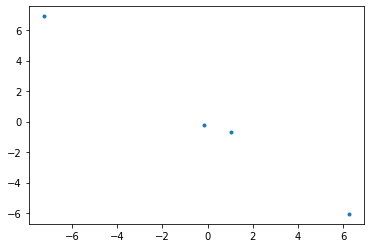

In [288]:
plt.plot(xy[...,1], xy[...,-1], ".")

In [289]:
q = net(xy.unsqueeze(0))

In [313]:
phi_x = xy[...,:-1]
y = xy[...,-1]

In [315]:
c = phi_x@phi_x.T

prior_mean = task.prior.mean 
prior_cov = torch.eye(prior.mean.shape[-1])*task.prior.variance 

likelihood_cov = torch.eye(c.shape[-1])*task.likelihood_scale**2

c = c + likelihood_cov
L_c = torch.cholesky(c)
inv_c = torch.cholesky_inverse(L_c)

post_m = task.prior.mean + prior_cov@phi_x.T@inv_c@(y - phi_x@task.prior.mean)
post_cov = prior_cov - prior_cov@phi_x.T@inv_c@phi_x@prior_cov

p_true = torch.distributions.MultivariateNormal(post_m, post_cov + torch.eye(2)*0.001)

#p_true = task.get_true_posterior().condition(xy)

In [326]:
p_true = task.get_true_posterior().condition(xy)

In [327]:
p_true.covariance_matrix

tensor([[[[5.8827e-02, 9.7270e-05],
          [9.8050e-05, 2.7025e-03]]]])

In [308]:
post_cov

tensor([[5.8826e-02, 9.7124e-05],
        [9.7007e-05, 2.7096e-03]])

In [329]:
samples = q.sample((10000,))
samples2 = p_true.sample((10000,))

c:\ProgramData\Miniconda3\lib\site-packages\sbi\analysis\plot.py:413: UserWarning: No contour levels were found within the data range.
  plt.contour(


(<Figure size 720x720 with 4 Axes>,
 array([[<AxesSubplot:xlabel='dim 1'>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:xlabel='dim 2'>]], dtype=object))

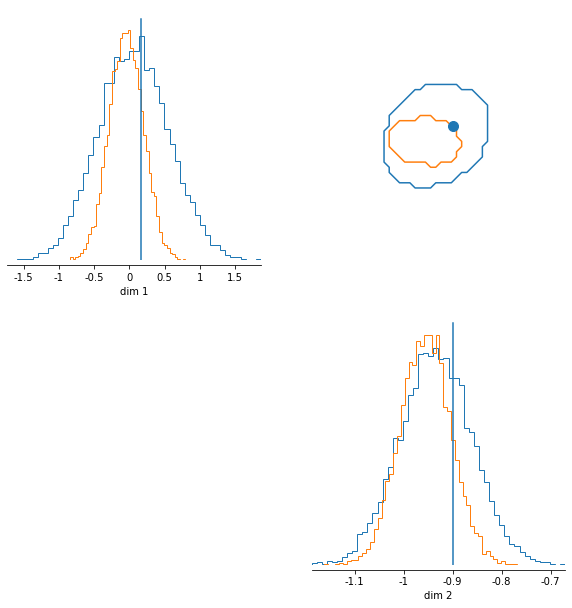

In [330]:
from sbi.analysis import pairplot

pairplot([samples.squeeze(), samples2.squeeze()], points=theta, upper="contour")

In [355]:
y.shape

torch.Size([2])

In [105]:
x_lin = torch.linspace(-10, 10, 1000).reshape(1,-1,1).repeat(100, 1, 1)
yyy = simulator(q.sample((100,)).squeeze(), x_lin).squeeze()[...,-1]

In [107]:
x_lin = torch.linspace(-10, 10, 1000).reshape(1,-1,1).repeat(100, 1, 1)
yyy = simulator(p_true.sample((100,)).squeeze(), x_lin).squeeze()[...,-1]

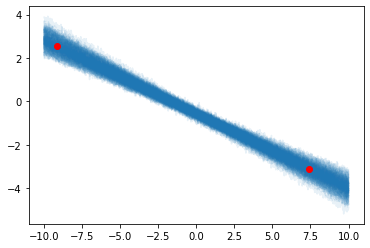

In [108]:
for x_i, y_i in zip(x_lin, yyy):
    plt.plot(x_i.flatten(), y_i.flatten(), color="C0", alpha=0.1)

plt.plot(xy[...,1], xy[...,-1] , "o", color="red")

In [122]:
x = torch.linspace(-5, 5, 100).reshape(-1, 1)

feature_mapping = lambda x: torch.hstack([torch.ones_like(x), x, x**2, x**3])

phi_x = feature_mapping(x)

w = torch.randn(10,4)

In [140]:
torch.tensor([[2.,2., torch.nan], [2.,2.,2.]])

tensor([[2., 2., nan],
        [2., 2., 2.]])

In [ ]:
def simulator()

In [123]:
import matplotlib.pyplot as plt

In [127]:
(phi_x@w.T).shape

torch.Size([100, 10])

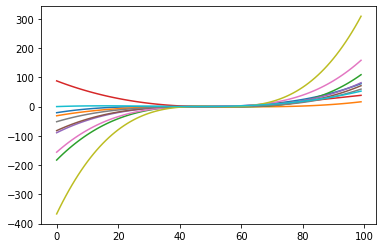

In [125]:
plt.plot(phi_x@w.T)